In [1]:
# Imports
import torch
import torch.nn.functional as F  # Parameterless functions, like (some) activation functions
import torchvision.datasets as datasets  # Standard datasets
import torchvision.transforms as transforms  # Transformations we can perform on our dataset for augmentation
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset  # Gives easier dataset managment by creating mini batches etc.
from sklearn.model_selection import train_test_split

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, f1_score, recall_score, precision_score


import sys


import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torch.autograd import Variable 
from torchvision import datasets, models, transforms
import time
import copy

In [2]:
#read the data 
#algorithm to read all the files

'''
for folder in this folder:
    read xelasensor1.csv
    read sliplabel.csv
    concat it in a single dataframe along axis = 0

print the dataframe
'''

directory = '/Users/elijahnelson/Desktop/SIWES/IML/Tactile_IML/train2dof'
directory2 = '/Users/elijahnelson/Desktop/SIWES/IML/Tactile_IML/'

def read_file(detect_or_pred, n = None):

    #store all directories in a list
    list_xela_allfiles = []
    list_sliplabel_allfiles = []

    for root, subdirectories, files in os.walk(directory):
        for sdirectory in subdirectories:

            #subdirectory with absolute path
            subdirectory = '{}/{}'.format(root, sdirectory)

            #read specific files in the subdirectory
            for file in os.listdir(subdirectory):
            
                if file.endswith("sensor1.csv"):
                    df = pd.read_csv('{}/{}'.format(subdirectory, file), index_col=None, header=0)
                    
                    if detect_or_pred ==0:
                        list_xela_allfiles.append(df)
                    elif detect_or_pred ==1 and n is not None:
                        list_xela_allfiles.append(df[:-n])

                if file.endswith("label.csv"):
                    df = pd.read_csv('{}/{}'.format(subdirectory, file), index_col=None, header=0)
                    if detect_or_pred ==0:
                        list_sliplabel_allfiles.append(df)
                    elif detect_or_pred ==1 and n is not None: 
                        list_sliplabel_allfiles.append(df[n:])

    return list_xela_allfiles, list_sliplabel_allfiles

    #np.newaxis; np.zeros (3,4,4) -> 
                    


# METRICS

In [3]:
def lstm_metrics(xela_test, sliplabel_test):
    #predict using the holdout set (DONE)
    predicted_cls = xela_test

    #Plot the loss values against number of epochs (DONE)
    #validation test (DONE)

    #Print the accuracy
    x = 0
    for i in range(predicted_cls.shape[0]):
        if predicted_cls[i, 0].item() == sliplabel_test[i, 0]:
            x += 1

    accuracy = x/ float(sliplabel_test.shape[0])
    print(f'Accuracy for slip detection is {accuracy}')

    #Print the fscore
    fscore = f1_score(sliplabel_test, predicted_cls, average='macro')
    print(f'Fscore for slip detection is {fscore}')

    #print the Precision
    precision = precision_score(sliplabel_test, predicted_cls, average='macro')
    print(f'Precision for slip detection is {precision}')

    #print the Recall
    recall = recall_score(sliplabel_test, predicted_cls, average='macro')
    print(f'Recall for slip detection is {recall}')

# READ DATA FROM FILES

In [4]:
#concat the list of xela_allfiles and sliplabel_allfiles across axis = 0
n = 5
list_xela_allfiles, list_sliplabel_allfiles = read_file(0)

#for slip prediction, comment the line above and uncomment the line below
#list_xela_allfiles, list_sliplabel_allfiles = read_file(1, n)

pd_xela_allfiles = pd.concat(list_xela_allfiles, axis=0, ignore_index=True)
pd_sliplabel_allfiles = pd.concat(list_sliplabel_allfiles, axis=0, ignore_index=True)
pd_sliplabel_allfiles = pd_sliplabel_allfiles['slip']

#reshape the target array into (rows, 1)
tac_label = pd_sliplabel_allfiles.values.reshape(pd_sliplabel_allfiles.shape[0], 1)

sc = StandardScaler()
pd_xela_allfiles = sc.fit_transform(pd_xela_allfiles)

# DATA SPLITTING

In [5]:
#split into train and validation
tac_train, tac_valid, tac_label_train, tac_label_valid = train_test_split(pd_xela_allfiles, tac_label, test_size=0.3, shuffle = True)

#convert to numpy values
data = tac_train#.to_numpy()
data_valid = tac_valid#.to_numpy()

labels = tac_label_train
labels_valid = tac_label_valid

#Arrange the data according to the desired sequence length
seq = 10
x = []
x_valid = []
for t in range(data.shape[0]-(seq-1)):
    x.append(data[t:t+seq])

for t in range(data_valid.shape[0]-(seq-1)):
    x_valid.append(data_valid[t:t+seq])

x = np.array(x)
x_valid = np.array(x_valid)

x_train = Variable(torch.Tensor(x))
x_train = torch.reshape(x_train,   (x_train.shape[0], seq, 48))

x_valid = Variable(torch.Tensor(x_valid))
x_valid = torch.reshape(x_valid,   (x_valid.shape[0], seq, 48))

y = labels[seq-1:]
y_valid = labels_valid[seq-1:]

y_train = Variable(torch.Tensor(y))
y_valid = Variable(torch.Tensor(y_valid))

pd_xela_allfiles = Variable(torch.Tensor(pd_xela_allfiles))
tac_label = Variable(torch.Tensor(tac_label))


x_train.shape, y_train.shape


(torch.Size([160746, 10, 48]), torch.Size([160746, 1]))

# DEFINE THE MODEL

In [6]:
#Define the model architecture

class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes 
        self.num_layers = num_layers 
        self.input_size = input_size 
        self.hidden_size = hidden_size 
        self.seq_length = seq_length 

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) 
        self.fc_1 =  nn.Linear(hidden_size, 32)
        self.fc = nn.Linear(32, num_classes) 

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) 
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) 
        
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) 
        hn = hn.view(-1, self.hidden_size)
        out = self.relu(hn)
        out = self.fc_1(out) 
        out = self.relu(out) 
        out = self.fc(out) 
        out = self.sigmoid(out)
        return out
        


# TRAIN THE MODEL

In [15]:
num_epochs = 500
learning_rate = 0.001

input_size = 48
hidden_size = 32
num_layers = 1
num_classes = 1 


model = LSTM1(num_classes, input_size, hidden_size, num_layers, x_train.shape[1])

# Loss and optimizer
weight = torch.Tensor([5])
loss = nn.BCELoss(weight=weight)#pos_weight=torch.tensor([2.0]))
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_loss = []
valid_loss = []
t_acc = []
v_acc = []
t_correct = 0
v_correct = 0

#Training loop
for epoch in range(num_epochs):
    model.train()
    outputs = model.forward(x_train)
    optimizer.zero_grad()
    l = loss(outputs, y_train)
    train_loss.append(l.item())
    l.backward()
    optimizer.step() 

    #accuracy
    t_correct += outputs.round().eq(y_train).sum().item()
    t_acc.append(t_correct/y_train.shape[0])

     #calculate and plot the validation loss
    model.eval()
    y_pred_test = model(x_valid)
    lv = loss(y_pred_test, y_valid)
    #append the loss per batch
    valid_loss.append(lv.item())

    #accuracy
    v_correct += y_pred_test.round().eq(y_valid).sum().item()
    v_acc.append(v_correct/y_valid.shape[0])
        
   
    #append the total loss and accuracy per epoch

    print(f'For training epoch {epoch+1}, loss ={l:.8f}', f'For validation epoch {epoch+1}, loss ={lv:.8f}'  )

For training epoch 1, loss =0.70213997 For validation epoch 1, loss =0.69640702
For training epoch 2, loss =0.69837016 For validation epoch 2, loss =0.69270575
For training epoch 3, loss =0.69469184 For validation epoch 3, loss =0.68910354
For training epoch 4, loss =0.69109124 For validation epoch 4, loss =0.68559492
For training epoch 5, loss =0.68755829 For validation epoch 5, loss =0.68213952
For training epoch 6, loss =0.68409085 For validation epoch 6, loss =0.67874402
For training epoch 7, loss =0.68068004 For validation epoch 7, loss =0.67541200
For training epoch 8, loss =0.67732245 For validation epoch 8, loss =0.67213905
For training epoch 9, loss =0.67400914 For validation epoch 9, loss =0.66891563
For training epoch 10, loss =0.67073840 For validation epoch 10, loss =0.66572636
For training epoch 11, loss =0.66750240 For validation epoch 11, loss =0.66257489
For training epoch 12, loss =0.66429597 For validation epoch 12, loss =0.65945286
For training epoch 13, loss =0.661

# TEST THE MODEL

Accuracy for slip detection is 0.9855705720963317
Fscore for slip detection is 0.9467536693126192
Precision for slip detection is 0.9557941267711845
Recall for slip detection is 0.9381309218133471


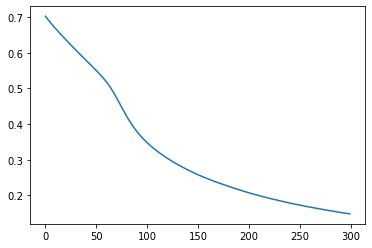

In [17]:
#validation 
y_predict = model.forward(x_valid)
y_predict = y_predict.round()
y_predict = y_predict.data.numpy()
y_valid = y_valid
lstm_metrics(y_predict, y_valid)

#print the loss
plt.plot(train_loss)

In [24]:
model.forward(x_valid)

tensor([[7.7758e-05],
        [2.4002e-06],
        [1.0070e-08],
        ...,
        [3.4911e-06],
        [1.5728e-05],
        [9.9251e-01]], grad_fn=<SigmoidBackward0>)

# Increase in the no of epochs increased Model's accuracy and generalization effect

In [21]:

# torch.save(model.state_dict(), "saved_models/LSTM_working2.pth")

In [22]:
# To load model

# newmodel = LSTM1(num_classes, input_size, hidden_size, num_layers, x_train.shape[1])
# newmodel.load_state_dict(torch.load("saved_models/LSTM_working.pth"))

<All keys matched successfully>